<a href="https://colab.research.google.com/github/adelardw/HSE-Kaggle-acoustic-championship/blob/main/HSE_kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle competitions download -c hse-itmo-acoustic-event-detection-2023

100% 7.33G/7.34G [06:22<00:00, 21.1MB/s]
100% 7.34G/7.34G [06:22<00:00, 20.6MB/s]


In [ ]:
!unzip /content/hse-itmo-acoustic-event-detection-2023.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: audio_train/train/1e1d3e022f56c156b4c7.wav  
  inflating: audio_train/train/1e280f74b308b6f20507.wav  
  inflating: audio_train/train/1e3bb494145d29683d5b.wav  
  inflating: audio_train/train/1e4626b1264b16cb8bfe.wav  
  inflating: audio_train/train/1e5494668fe5055092a0.wav  
  inflating: audio_train/train/1e57c2be7296212fbe9e.wav  
  inflating: audio_train/train/1e616116120b9706516a.wav  
  inflating: audio_train/train/1e6fbb2e48198873d22e.wav  
  inflating: audio_train/train/1e7a81713bb0e482a21b.wav  
  inflating: audio_train/train/1e7d1b5f4c78d78353e2.wav  
  inflating: audio_train/train/1e7f2f384ee98e31345d.wav  
  inflating: audio_train/train/1e82f46834ec5949995b.wav  
  inflating: audio_train/train/1e917fa34ac2fecb5eed.wav  
  inflating: audio_train/train/1ea0ac9647c2e889e62d.wav  
  inflating: audio_train/train/1eaa75ad36f4c10eac71.wav  
  inflating: audio_train/train/1eb1379ed30da224621b.wav  
  in

In [ ]:
import torch
import librosa
import numpy as np
import sklearn

import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

In [ ]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db


def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(y = wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(y =wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))

In [ ]:
train_folder = '/content/audio_train/train'
test_folder = '/content/audio_test/test'

sample_rate = 1600
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

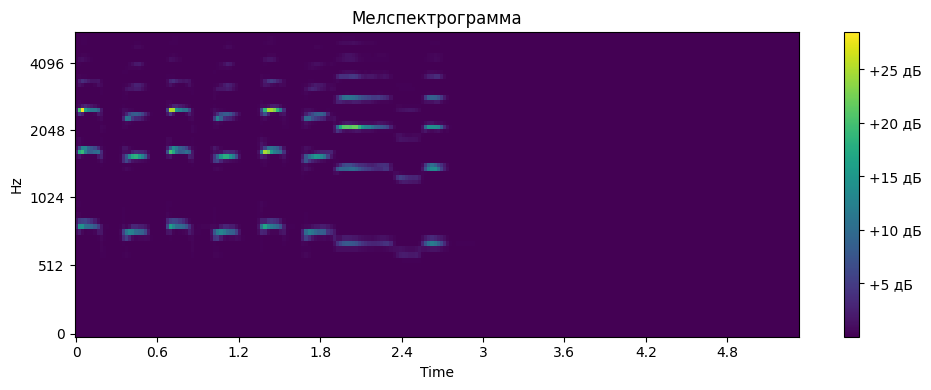

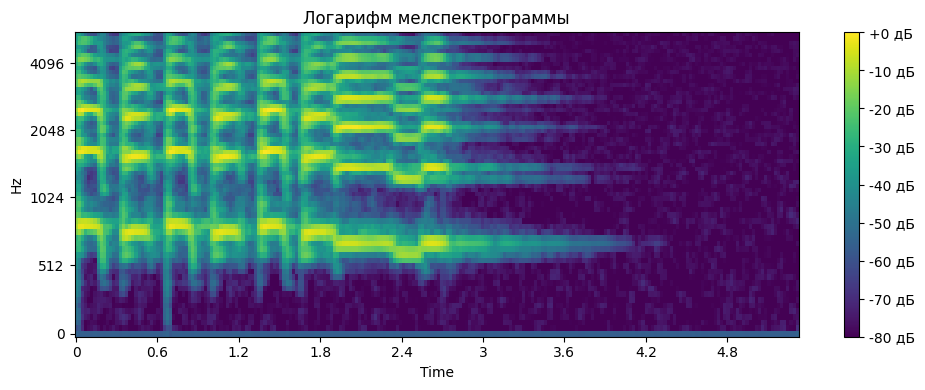

In [ ]:
wav_data, sr = load(os.path.join(test_folder, '0a9f4e787d8d2af55683.wav'), sr=sample_rate)
mel_spec = melspectrogram(y = wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels,
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [ ]:

path_to_csv = os.path.join('/content/', 'train.csv')

pickle_train_path = os.path.join('train.pickle')
pickle_test_path = os.path.join('/content/', 'test.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]


Total files: 5683


5683it [01:48, 52.32it/s]


In [ ]:

extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

3790it [01:03, 59.97it/s]


In [ ]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


In [ ]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [ ]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [ ]:

validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [ ]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [ ]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

14


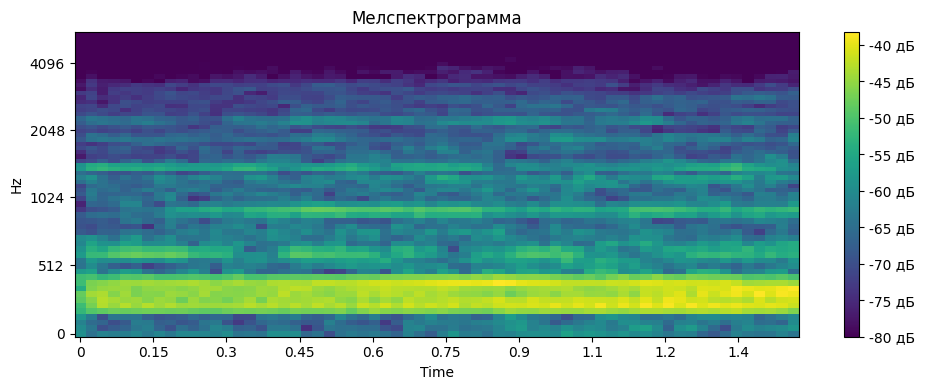

In [ ]:
sample_x, sample_y = val_dset[2]
print(sample_y)
# print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=64, shuffle=False, num_workers=0)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
device ='cuda:0'

In [ ]:
model = nn.Sequential(

        nn.Conv2d(in_channels=1, out_channels=128, kernel_size= 2, padding= 2,stride = (1,1)),
        nn.SiLU(),
        nn.BatchNorm2d(num_features=128),
        nn.MaxPool2d(kernel_size=(2, 2)),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size= 2, padding= 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(p=0.3),

        nn.Conv2d(in_channels=256, out_channels=512, kernel_size= 2),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2),
        nn.BatchNorm2d(num_features=1024),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)),

        nn.Conv2d(in_channels=1024, out_channels = 2048, kernel_size=2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=2048),
        nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)),
        nn.Dropout(p=0.3),

        nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=2),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=512),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(p=0.3),
        nn.Flatten(),


        nn.Linear(18432, 512),
        nn.SiLU(),
        nn.Linear(512,256),
        nn.SiLU(),
        nn.Linear(256,128),
        nn.SiLU(),
        nn.Linear(128,41),

).to(device)

In [ ]:
from torchsummary import summary

summary(model, input_size= (1, 64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 67, 67]             640
              SiLU-2          [-1, 128, 67, 67]               0
       BatchNorm2d-3          [-1, 128, 67, 67]             256
         MaxPool2d-4          [-1, 128, 33, 33]               0
            Conv2d-5          [-1, 256, 36, 36]         131,328
              ReLU-6          [-1, 256, 36, 36]               0
         MaxPool2d-7          [-1, 256, 18, 18]               0
           Dropout-8          [-1, 256, 18, 18]               0
            Conv2d-9          [-1, 512, 17, 17]         524,800
             ReLU-10          [-1, 512, 17, 17]               0
           Conv2d-11         [-1, 1024, 16, 16]       2,098,176
      BatchNorm2d-12         [-1, 1024, 16, 16]           2,048
        MaxPool2d-13         [-1, 1024, 15, 15]               0
           Conv2d-14         [-1, 2048,

In [ ]:
from torch import optim

In [ ]:
impo

In [ ]:
torch.cuda.empty_cache()

In [ ]:


n_epoch = 75
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.00001, weight_decay=0.0003)

In [ ]:
class TrainProcess:

  def __init__(self, train_data, test_data):
    self.train_data = train_data
    self.test_data = test_data


  def train_proc(self, model, optimiser, loss_function):
    size_train = self.train_data.dataset.__len__()
    train_loss = 0
    num_batches = len(self.train_data)
    best_score = 0
    for batch, (X, y) in enumerate(self.train_data):
        X = X.to(device).to(torch.float32)
        y = y.to(device)

        pred = model(X)
        loss = loss_function(pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size_train:>5d}]")

    acc = accuracy_score(torch.Tensor.cpu(y).detach().numpy(), torch.Tensor.cpu(pred).detach().numpy().argmax(axis=1))
    f1 = f1_score(torch.Tensor.cpu(y).detach().numpy(), torch.Tensor.cpu(pred).detach().numpy().argmax(axis=1),average = 'macro')
    print(f"Scklearn acc train: \n Accuracy: {(100*acc):>0.1f}% \n")
    print(f'Sklearn f1 score: \n {f1}' )
    train_loss /= num_batches
    return train_loss


  def test_proc(self, model, loss_func):
    size_test = self.test_data.dataset.__len__()
    num_batches = len(self.test_data)
    test_loss, correct = 0, 0


    with torch.no_grad():
        for X, y in self.test_data:
            X = X.to(device).to(torch.float32)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size_test


    acc = accuracy_score(torch.Tensor.cpu(y).detach().numpy(), torch.Tensor.cpu(pred).detach().numpy().argmax(axis=1))
    f1 = f1_score(torch.Tensor.cpu(y).detach().numpy(), torch.Tensor.cpu(pred).detach().numpy().argmax(axis=1),average = 'macro')
    print(f'Sklearn test f1 score: \n {f1}' )
    print(f"Scklearn acc test: \n Accuracy: {(100*acc):>0.1f}% \n")

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return f1,test_loss

  def lets_do_this(self, model_,loss_funct, optim, epochs = 12, plt_curve = True):
    train_loss_history = []
    test_loss_history = []
    best_score = 0
    #try:
    for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")

            train_loss = TrainProcess(self.train_data,self.test_data).train_proc(model_, optim, loss_funct,)
            train_loss_history.append(train_loss)

            score,test_loss = TrainProcess(self.train_data,self.test_data).test_proc(model_, loss_funct)
            test_loss_history.append(test_loss)
            if score > best_score:
                best_score = score
                torch.save(model.state_dict(), '/content/model_one')

    #except: KeyboardInterrupt
    print("Done!")
    if plt_curve == True:
      n_epochs = len(train_loss_history)
      plt.plot(np.arange(0, n_epochs), train_loss_history, label='train loss')
      plt.plot(np.arange(0, n_epochs), test_loss_history, label='test loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title('Loss curve')
      plt.legend()
      return train_loss_history, test_loss_history
    else:
      return train_loss_history, test_loss_history

Epoch 1
-------------------------------
Train loss: 3.722820  [   64/ 4883]
Train loss: 3.689344  [  704/ 4883]
Train loss: 3.656849  [ 1344/ 4883]
Train loss: 3.596570  [ 1984/ 4883]
Train loss: 3.608179  [ 2624/ 4883]
Train loss: 3.470471  [ 3264/ 4883]
Train loss: 3.412372  [ 3904/ 4883]
Train loss: 3.229267  [ 4544/ 4883]
Scklearn acc train: 
 Accuracy: 5.3% 

Sklearn f1 score: 
 0.0392156862745098
Sklearn test f1 score: 
 0.11966873706004139
Scklearn acc test: 
 Accuracy: 21.9% 

Test Error: 
 Accuracy: 18.2%, Avg loss: 3.220566 

Epoch 2
-------------------------------
Train loss: 3.374551  [   64/ 4883]
Train loss: 3.081580  [  704/ 4883]
Train loss: 3.105046  [ 1344/ 4883]
Train loss: 3.151815  [ 1984/ 4883]
Train loss: 2.886719  [ 2624/ 4883]
Train loss: 3.199363  [ 3264/ 4883]
Train loss: 3.082586  [ 3904/ 4883]
Train loss: 2.915254  [ 4544/ 4883]
Scklearn acc train: 
 Accuracy: 15.8% 

Sklearn f1 score: 
 0.12
Sklearn test f1 score: 
 0.15066666666666667
Scklearn acc test: 


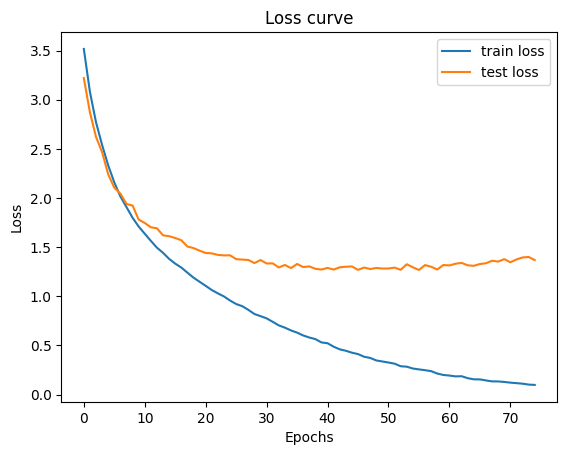

In [ ]:
initilize = TrainProcess(train_loader, val_loader)

tr_C, te_C = initilize.lets_do_this(model_ = model,
                                      loss_funct = criterion,
                                      optim = optimizer,
                                      epochs = n_epoch)